# Imports


In [196]:
!pip install xgboost
!pip install dateparser
!pip install catboost

In [197]:
import pandas as pd
import numpy as np
import re
import time
import json
import csv
import ast
import joblib
import cloudpickle
import requests
import dateparser
from datetime import datetime
from bs4 import BeautifulSoup
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import kendalltau
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MultiLabelBinarizer,
    OneHotEncoder,
    StandardScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.impute import KNNImputer
import warnings

In [198]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Reading CSVs & Merging

In [199]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [200]:
df_demo = pd.read_csv('/content/drive/MyDrive/ML DataSet/demos.csv')
df_dlc = pd.read_csv('/content/drive/MyDrive/ML DataSet/dlcs.csv')
#df_steam = pd.read_csv('/content/drive/MyDrive/ML DataSet/gamalytic_steam_games.csv')
df_steam = pd.read_csv("/content/drive/MyDrive/ML DataSet/ms2_gamalytic_steam_games.csv")
df_info = pd.read_csv('/content/drive/MyDrive/ML DataSet/info_base_games.csv')

<ipython-input-200-5babad051e33>:5: DtypeWarning:

Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.



In [201]:
def merge_game_dataframes(df_info, df_steam, df_dlc, df_demo):

    df_demo.rename(columns={'full_game_appid': 'steam_id'}, inplace=True)
    df_dlc.rename(columns={'base_appid': 'steam_id'}, inplace=True)
    df_steam.rename(columns={'steamId': 'steam_id'}, inplace=True)
    df_info.rename(columns={'appid': 'steam_id'}, inplace=True)

    df_info.rename(columns={'name': 'name_info'}, inplace=True)
    df_dlc.rename(columns={'name': 'name_dlc'}, inplace=True)
    df_demo.rename(columns={'name': 'name_demo'}, inplace=True)

    df_info['steam_id'] = df_info['steam_id'].astype(str)
    df_steam['steam_id'] = df_steam['steam_id'].astype(str)
    df_dlc['steam_id'] = df_dlc['steam_id'].astype(str)
    df_demo['steam_id'] = df_demo['steam_id'].astype(str)

    final_df = pd.merge(df_info, df_steam, on='steam_id', how='outer')
    final_df = pd.merge(final_df, df_dlc[['steam_id', 'dlc_appid', 'name_dlc']], on='steam_id', how='left')
    final_df = pd.merge(final_df, df_demo[['steam_id', 'demo_appid', 'name_demo']], on='steam_id', how='left')

    return final_df

intial_df = merge_game_dataframes(df_info, df_steam, df_dlc, df_demo)

# Dropping Unnecessary columns
intial_df = intial_df.drop('aiContent', axis=1)
#intial_df = intial_df.drop('Unnamed: 0', axis=1)
intial_df = intial_df.drop('name_demo', axis=1)
intial_df = intial_df.drop('name_dlc', axis=1)

In [202]:
#New_merged_df = pd.read_csv('/content/drive/MyDrive/ML DataSet/last.csv')

In [203]:
# temp = pd.read_csv("/content/drive/MyDrive/ML DataSet/ms2_gamalytic_steam_games.csv")

In [204]:
# New_merged_df = New_merged_df.merge(
#     temp[['steamId', 'copiesSold']],
#     left_on='steam_id',
#     right_on='steamId',
#     how='outer'
# )

# # Optionally drop the redundant 'steamId' column after merging
# New_merged_df = New_merged_df.drop(columns=['steamId'])

In [205]:
# New_merged_df.to_csv('MS2.csv')

**Fetching Data**

In [206]:
# fetch_pipeline = joblib.load('fetch_pipeline.joblib')
# fetch_df = fetch_pipeline.fit_transform(intial_df)
fetch_df = pd.read_csv('/content/drive/MyDrive/ML DataSet/last.csv')

In [207]:
fetch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121659 entries, 0 to 121658
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   steam_id             121659 non-null  int64  
 1   name_info            121641 non-null  object 
 2   metacritic           121659 non-null  int64  
 3   steam_achievements   121659 non-null  int64  
 4   steam_trading_cards  121659 non-null  int64  
 5   workshop_support     121659 non-null  int64  
 6   genres               116996 non-null  object 
 7   achievements_total   121659 non-null  int64  
 8   release_date         121351 non-null  object 
 9   coming_soon          121659 non-null  int64  
 10  support_windows      121659 non-null  int64  
 11  support_mac          121659 non-null  int64  
 12  support_linux        121659 non-null  int64  
 13  has_dlc              121659 non-null  int64  
 14  has_demo             121659 non-null  int64  
 15  dlc_appid        

In [208]:
fetch_df = fetch_df.drop('dlc_appid', axis=1)
fetch_df = fetch_df.drop('demo_appid', axis=1)

In [209]:
initial_selected = intial_df[['steam_id', 'copiesSold', 'reviewScore', 'publisherClass']]
fetch_df['steam_id'] = fetch_df['steam_id'].astype(str)
fetch_df = fetch_df.merge(initial_selected, on='steam_id', how='left')

In [210]:
fetch_df = fetch_df.drop('name_dlc', axis=1)
fetch_df = fetch_df.drop('name_demo', axis=1)

In [211]:
# Dropping duplicates due to fetching and null copies sold
print(fetch_df.duplicated().sum())
fetch_df.drop_duplicates(inplace=True)

10296


In [212]:
fetch_df.shape

(118227, 26)

In [213]:
fetch_df.columns

Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass'],
      dtype='object')

In [214]:
fetch_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118227 entries, 0 to 128522
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   steam_id             118227 non-null  object 
 1   name_info            118209 non-null  object 
 2   metacritic           118227 non-null  int64  
 3   steam_achievements   118227 non-null  int64  
 4   steam_trading_cards  118227 non-null  int64  
 5   workshop_support     118227 non-null  int64  
 6   genres               113864 non-null  object 
 7   achievements_total   118227 non-null  int64  
 8   release_date         117924 non-null  object 
 9   coming_soon          118227 non-null  int64  
 10  support_windows      118227 non-null  int64  
 11  support_mac          118227 non-null  int64  
 12  support_linux        118227 non-null  int64  
 13  has_dlc              118227 non-null  int64  
 14  has_demo             118227 non-null  int64  
 15  publisher            1

In [215]:
(fetch_df.isnull().sum()/len(fetch_df))*100

,0
steam_id,0.000000
name_info,0.015225
metacritic,0.000000
steam_achievements,0.000000
steam_trading_cards,0.000000
workshop_support,0.000000
genres,3.690358
achievements_total,0.000000
release_date,0.256287
coming_soon,0.000000


# Splitting the data

In [216]:
print(fetch_df['copiesSold'].unique())

['Platinum' nan 'Silver' 'Gold' 'Bronze']


In [217]:
# train(df): 70%, validation(val_df): 10%, test(test_df): 20%
df, temp_df = train_test_split(fetch_df, test_size=0.30, random_state=42, shuffle=True)
# Step 2: Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.67, random_state=42, shuffle=True)

In [218]:
print(df['copiesSold'].unique())

['Bronze' 'Platinum' 'Gold' 'Silver' nan]


# Applying the preprocessing pipeline

In [219]:
def compute_train_mappings(df):
    mappings = {}

    # Remove invalid values before computing modes/means
    valid_publisher_class = df['publisherClass'].notna() & (df['publisherClass'] != -1)
    valid_price = df['price'].notna()
    valid_genres = df['genres'].notna() & (df['genres'] != 'unknown')

    # PublisherClass mappings
    mappings['publisherClass_by_publisher'] = (
        df[valid_publisher_class]
        .groupby('publisher')['publisherClass']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        .to_dict()
    )

    mappings['publisherClass_by_developer'] = (
        df[valid_publisher_class]
        .groupby('developer')['publisherClass']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        .to_dict()
    )

    # Global mode for publisherClass (fallback)
    if not df[valid_publisher_class]['publisherClass'].empty:
        mappings['global_mode_publisherClass'] = df[valid_publisher_class]['publisherClass'].mode().iloc[0]
    else:
        mappings['global_mode_publisherClass'] = None

    # Price mappings
    mappings['price_by_publisher'] = (
        df[valid_price]
        .groupby('publisher')['price']
        .mean()
        .to_dict()
    )

    mappings['price_by_developer'] = (
        df[valid_price]
        .groupby('developer')['price']
        .mean()
        .to_dict()
    )

    # Global mean for price (fallback)
    mappings['global_price'] = df[valid_price]['price'].mean()

    # Genre mappings
    mappings['genre_by_publisher'] = (
        df[valid_genres]
        .groupby('publisher')['genres']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        .to_dict()
    )

    mappings['genre_by_developer'] = (
        df[valid_genres]
        .groupby('developer')['genres']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        .to_dict()
    )

    # Global mode for genres (fallback)
    if not df[valid_genres]['genres'].empty:
        mappings['global_genre'] = df[valid_genres]['genres'].mode().iloc[0]
    else:
        mappings['global_genre'] = None

    # Medians grouped by copiesSold
    mappings['median_reviewScore_by_copiesSold'] = (
        df.groupby('copiesSold')['reviewScore']
        .median()
        .to_dict()
    )

    mappings['median_achievements_total_by_copiesSold'] = (
        df.groupby('copiesSold')['achievements_total']
        .median()
        .to_dict()
    )

    mappings['median_recommendations_by_copiesSold'] = (
        df.groupby('copiesSold')['recommendations']
        .median()
        .to_dict()
    )

    # Add global medians as fallback**
    mappings['global_median_reviewScore'] = df['reviewScore'].median()
    mappings['global_median_achievements_total'] = df['achievements_total'].median()
    mappings['global_median_recommendations'] = df['recommendations'].median()

    return mappings

In [220]:
def encode_copiesSold(df):
    mapping = {
        'Bronze': 0,
        'Silver': 1,
        'Gold': 2,
        'Platinum': 3,
        'Not realeased': 4,
        'default': 5
    }
    df['copiesSold'] = df['copiesSold'].map(mapping).fillna(mapping['default']).astype(int)
    return df

def update_coming_soon_inplace(df):
    condition_coming_soon = (df['coming_soon'] == 1) & (df['copiesSold'].isna())
    df.loc[condition_coming_soon & (df['is_free'] == 1), ['price', 'reviewScore', 'recommendations', 'copiesSold']] = 0
    df.loc[condition_coming_soon, ['reviewScore', 'recommendations', 'copiesSold']] = 0
    return df

def update_coming_soon_MS2(df):

    condition_coming_soon = (df['coming_soon'] == 1) & (df['copiesSold'].isna())
    df.loc[condition_coming_soon , ['copiesSold']] = 'Not realeased'
    return df

def drop_copies_sold_na(df):
    df.dropna(subset=['copiesSold'], inplace=True)
    return df

def fill_by_copiesSold_medians(df):

    cols = ['reviewScore', 'achievements_total', 'recommendations']
    median_keys = ['median_reviewScore_by_copiesSold',
                   'median_achievements_total_by_copiesSold',
                   'median_recommendations_by_copiesSold']

    for col, median_key in zip(cols, median_keys):
        if col in df.columns and median_key in mappings:
            median_dict = mappings[median_key]
            global_median = mappings.get(f'global_median_{col}', None)

            mapped = df['copiesSold'].map(median_dict)

            df[col] = df[col].fillna(mapped)
            if global_median is not None and not pd.isna(global_median):
                df[col] = df[col].fillna(global_median)

    return df


def fill_publisher_class(df):
    global_publisherclass_mode=mappings['global_mode_publisherClass']
    publisher_mode_mapping=mappings['publisherClass_by_publisher']
    developer_mode_mapping=mappings['publisherClass_by_developer']

    df = df.copy()

    if 'publisher' in df.columns and 'publisherClass' in df.columns:
        values_to_fill_mask = (df['publisherClass'] == -1) | (df['publisherClass'].isna())
        if publisher_mode_mapping:
            mode_for_each_row = df['publisher'].map(publisher_mode_mapping)
            fill_locations = values_to_fill_mask & mode_for_each_row.notna()
            df.loc[fill_locations, 'publisherClass'] = mode_for_each_row[fill_locations]

    if 'developer' in df.columns and 'publisherClass' in df.columns:
        values_to_fill_mask = (df['publisherClass'] == -1) | (df['publisherClass'].isna())
        if developer_mode_mapping:
            mode_for_each_row = df['developer'].map(developer_mode_mapping)
            fill_locations = values_to_fill_mask & mode_for_each_row.notna()
            df.loc[fill_locations, 'publisherClass'] = mode_for_each_row[fill_locations]

    if 'publisherClass' in df.columns and global_publisherclass_mode is not None:
        df['publisherClass'].fillna(global_publisherclass_mode, inplace=True)
        df.loc[df['publisherClass'] == -1, 'publisherClass'] = global_publisherclass_mode

    return df

def preprocess_publisher_data(df):
    publisher_class_mapping = {
        0: 'AAA',
        1: 'Indie',
        2: 'AA',
        3: 'Hobbyist',
        4: 'Other'
    }

    valid_class_names = {
        'AAA': 0,
        'Indie': 1,
        'AA': 2,
        'Hobbyist': 3,
        'Other': 4
    }

    if 'publisher' in df.columns and 'publisherClass' in df.columns:
        df['publisherClass'] = df['publisherClass'].fillna(-1)
        if not df.empty:
            df['publisherClass'] = df['publisherClass'].replace(valid_class_names)
            df['publisherClass'] = df['publisherClass'].apply(lambda x: 4 if isinstance(x, str) else x)

    return df
def is_missing_price(series):
    mask = series.isna()
    if pd.api.types.is_string_dtype(series):
        mask = mask | (series == '') | (series.str.strip() == '')
    return mask

def fill_price_hierarchically_inplace(df):
    publisher_means=mappings['price_by_publisher']
    developer_means=mappings['price_by_developer']
    global_price=mappings['global_price']
    df = df.copy()
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')

    if publisher_means and {'price', 'publisher'}.issubset(df.columns):
        initial_mask = is_missing_price(df['price'])
        mapped_publisher_mean = df['publisher'].map(publisher_means)
        fill_mask = initial_mask & df['publisher'].notna() & mapped_publisher_mean.notna()
        df.loc[fill_mask, 'price'] = mapped_publisher_mean[fill_mask]

    if developer_means and {'price', 'developer'}.issubset(df.columns):
        remaining_mask = is_missing_price(df['price'])
        mapped_dev_mean = df['developer'].map(developer_means)
        fill_mask = remaining_mask & df['developer'].notna() & mapped_dev_mean.notna()
        df.loc[fill_mask, 'price'] = mapped_dev_mean[fill_mask]

    if global_price is not None:
        df['price'].fillna(global_price, inplace=True)

    return df

def translate_genres(df):
    genre_translation = {
        'Acción': 'Action', 'Ação': 'Action', 'アクション': 'Action', 'Экшены': 'Action',
        'Aventura': 'Adventure', 'Приключенческие игры': 'Adventure', 'アドベンチャー': 'Adventure',
        'Casual': 'Casual', 'Казуальные игры': 'Casual', 'カジュアル': 'Casual', 'Indépendant': 'Indie',
        'Инди': 'Indie', 'インディー': 'Indie', 'Simuladores': 'Simulation', 'シミュレーション': 'Simulation',
        'Stratégie': 'Strategy', 'Estrategia': 'Strategy', 'Strategie': 'Strategy', 'Sport': 'Sports',
        'Course automobile': 'Racing', 'Бесплатные': 'Free To Play', 'Grátis para Jogar': 'Free To Play',
        '無料プレイ': 'Free To Play', 'Accès anticipé': 'Early Access', 'Ранний доступ': 'Early Access',
        '早期アクセス': 'Early Access', 'Ролевые игры': 'RPG', 'Violent': 'Violent', 'Gore': 'Gore',
        'Nudity': 'Nudity', 'Sexual Content': 'Sexual Content', 'MM（Massively Multiplayer）': 'Massively Multiplayer',
        '액션': 'Action', 'Бесплатные': 'Free To Play', 'Ролевые игры': 'RPG', 'Экшены': 'Action', 'Tutorial': 'Software Training',
        'Documentary': 'Education', 'Short': 'Creative Tools', 'Movie': 'Creative Tools'
    }

    if 'genres' in df.columns:
        def safe_translate(genre):
            if pd.isna(genre) or not isinstance(genre, str):
                return 'Unknown'

            try:
                base_genre = genre.split('（')[0].strip().replace('）', '')
                return genre_translation.get(base_genre, genre)
            except (AttributeError, TypeError):
                return genre

        df['genres'] = df['genres'].apply(safe_translate)
    else:
        df['genres'] = 'Unknown'

    return df
import pandas as pd
import numpy as np

def is_missing_or_unknown_genre(series):
    mask = series.isna()
    if pd.api.types.is_string_dtype(series):
        mask = mask | (series == '') | (series.str.strip() == '')
        mask = mask | (series.str.lower() == 'unknown')
    if series.apply(lambda x: isinstance(x, list)).any():
        mask = mask | series.apply(lambda x: isinstance(x, list) and len(x) == 0)
    return mask

def fill_missing_genres(df):
    publisher_mode_mapping=mappings['genre_by_publisher']
    developer_mode_mapping=mappings['genre_by_developer']
    global_mode_genre=mappings['global_genre']
    df = df.copy()
    if {'genres', 'publisher'}.issubset(df.columns) and publisher_mode_mapping:
        initial_mask = is_missing_or_unknown_genre(df['genres'])
        mapped = df['publisher'].map(publisher_mode_mapping)
        fill_mask = initial_mask & df['publisher'].notna() & mapped.notna()
        df.loc[fill_mask, 'genres'] = mapped[fill_mask]

    if {'genres', 'developer'}.issubset(df.columns) and developer_mode_mapping:
        remaining_mask = is_missing_or_unknown_genre(df['genres'])
        mapped = df['developer'].map(developer_mode_mapping)
        fill_mask = remaining_mask & df['developer'].notna() & mapped.notna()
        df.loc[fill_mask, 'genres'] = mapped[fill_mask]

    if global_mode_genre is not None:
        df.loc[is_missing_or_unknown_genre(df['genres']), 'genres'] = global_mode_genre

    return df

def standardize_date(date_str):
    coming_soon_phrases = ['to be announced', 'coming soon', 'maybe', 'em breve', 'binnenkort verwacht']
    if any(phrase in str(date_str).lower() for phrase in coming_soon_phrases):
        return (None, 1)

    quarter_match = re.match(r'Q([1-4])\s*(\d{4})', str(date_str), re.IGNORECASE)
    if quarter_match:
        quarter = int(quarter_match.group(1))
        year = int(quarter_match.group(2))
        month = (quarter - 1) * 3 + 1
        return (f"{year}-{month:02d}-01", 0)

    if re.fullmatch(r'\d{4}', str(date_str)):
        return (f"{date_str}-01-01", 0)

    parsed_date = dateparser.parse(
        str(date_str),
        languages=['en', 'ru', 'fr', 'es', 'zh', 'ko', 'de', 'nl', 'pt'],
        settings={'PREFER_DAY_OF_MONTH': 'first'}
    )

    if parsed_date:
        return (parsed_date.strftime("%Y-%m-%d"), 0)
    else:
        return (None, 1)

def apply_standardize_dates(df):
    df[['standardized_date', 'coming_soon']] = df['release_date'].apply(
        lambda x: pd.Series(standardize_date(x))
    )
    return df
def categorize_genre(genre, category_map, default='Uncategorized'):

    for category, subcategories in category_map.items():
        if genre in subcategories:
            return category
    return default

def update_genres_with_categories(df):

    category_map = {
        'Core Games': ['Action', 'Adventure', 'RPG', 'Strategy', 'Simulation', 'Episodic'],
        'Casual & Social Games': [
            'Casual', 'Free To Play', 'Massively Multiplayer', 'Early Access', 'MM（Massively Multiplayer）'
        ],
        'Sports & Racing': ['Sports', 'Racing'],
        'Indie': ['Indie'],
        'Education & Training': ['Education', 'Software Training', 'Documentary', 'Tutorial'],
        'Creative Tools': [
            'Animation & Modeling', 'Design & Illustration', 'Photo Editing',
            'Video Production', 'Audio Production', 'Web Publishing',
            'Game Development', 'Short', 'Movie'
        ],
        'Productivity Tools': ['Utilities', 'Accounting'],
        'Mature Content': ['Violent', 'Gore', 'Nudity', 'Sexual Content']
    }

    exploded_genres = (
        df['genres']
        .str.split(r',\s*')
        .explode()
        .str.strip()
        .str.replace(r'[（）]', '', regex=True)
        .to_frame()
        .reset_index()
    )
    exploded_genres['category'] = exploded_genres['genres'].apply(
        lambda g: categorize_genre(g, category_map=category_map)
    )
    df = df.join(
        exploded_genres.groupby('index')['category']
        .agg(lambda x: list(set(x)))
        .rename('categories')
    )

    return df
def count_total_languages(language_str):
    if pd.isna(language_str) or language_str == "No info":
        return 1
    languages = [lang.strip() for lang in language_str.split(',') if lang.strip()]
    return len(languages) if languages else 1

def add_total_languages_column(df):
    df['total_languages'] = df['languages_clean_str'].apply(count_total_languages)
    return df
def force_list(x):
    if isinstance(x, (list, tuple, set)):
        return list(x)
    else:
        return []

def MultiLabelBinarizer_encode_categories(df):
    df['categories'] = df['categories'].apply(force_list)
    mlb = MultiLabelBinarizer()
    onehot = mlb.fit_transform(df['categories'])
    onehot_df = pd.DataFrame(onehot, columns=mlb.classes_, index=df.index)
    df = pd.concat([df, onehot_df], axis=1)
    return df
def replace_age_rating(df):
    df['age_rating'].replace('m', 17, inplace=True)
    df['age_rating'].replace('z', 18, inplace=True)
    df['age_rating'].replace('stats', 1, inplace=True)
    df['age_rating'].replace('ec',3, inplace=True)
    df['age_rating'].replace('b', 12, inplace=True)
    df['age_rating'].replace('ao', 18, inplace=True)
    df['age_rating'].replace('c', 15, inplace=True)
    df['age_rating'].replace('rpm', 14, inplace=True)
    df['age_rating'].replace('rp', 17, inplace=True)
    df['age_rating'].replace('d', 17, inplace=True)
    df['age_rating'].replace('e', 6, inplace=True)
    df['age_rating'].replace('a', 1, inplace=True)
    df['age_rating'].replace('e10', 10, inplace=True)
    df['age_rating'].replace('t', 13, inplace=True)
    df['age_rating'] = pd.to_numeric(df['age_rating'], errors='coerce')
    return df
def encode_supported_platforms(df):

    df['supported_platforms'] = df['supported_platforms'].apply(
        lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else
                 (x if isinstance(x, list) else [])
    )

    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df['supported_platforms'])

    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    encoded_df.columns = ['support_' + col.lower() for col in encoded_df.columns]
    result_df = pd.concat([df, encoded_df], axis=1)

    return result_df
def booleans_encoding(df):

    boolean_features = [
        'steam_achievements',
        'steam_trading_cards',
        'workshop_support'
    ]
    for feature in boolean_features:
        if feature in df.columns:
            df[feature] = df[feature].map({True: 1, False: 0}).fillna(-1)
    df['has_demo'] = df[['demo_appid', 'name_demo']].notna().any(axis=1).astype(int)
    df['has_dlc'] = df[['dlc_appid', 'name_dlc']].notna().any(axis=1).astype(int)
    df['has_demo'] = df['has_demo'].fillna(0).astype(int)
    df['has_dlc'] = df['has_dlc'].fillna(0).astype(int)

    return df

def calculate_coming_soon(row):
    release_date_str = row['release_date']
    is_coming_soon_api = row['coming_soon']

    if pd.notna(is_coming_soon_api) and int(is_coming_soon_api) == 1:
        return 1

    if pd.isna(release_date_str) or release_date_str in ['', 'No info']:
        return 1

    parsed_date = dateparser.parse(
        str(release_date_str),
        languages=['en', 'ru', 'fr', 'es', 'zh', 'ko', 'de', 'nl', 'pt'],
        settings={'PREFER_DAY_OF_MONTH': 'first'}
    )

    if parsed_date is None:
        return 1

    current_date = datetime.now()

    if parsed_date > current_date:
        return 1

    return 0

def update_coming_soon_column(df):

    if 'coming_soon' not in df.columns:
        df['coming_soon'] = 0

    df['coming_soon'] = df.apply(calculate_coming_soon, axis=1)

    return df
def fill_nulls(df):

  df_result = df.copy()

  if 'support_windows' in df_result.columns:
    df_result['support_windows'] = df_result['support_windows'].fillna(1)
    df_result['support_windows'] = pd.to_numeric(df_result['support_windows'], errors='coerce').fillna(1).astype(int)
  for col in ['support_linux', 'support_mac']:
    if col in df_result.columns:
      df_result[col] = df_result[col].fillna(0)
      df_result[col] = pd.to_numeric(df_result[col], errors='coerce').fillna(0).astype(int)
  df_result['age_rating'] = df_result['age_rating'].fillna(1)
  df_result['age_rating'] = pd.to_numeric(df_result['age_rating'], errors='coerce').fillna(1).astype(int)
  df_result['controller_support'] = df_result['controller_support'].fillna(0)
  df_result['controller_support'] = pd.to_numeric(df_result['controller_support'], errors='coerce').fillna(0).astype(int)
  df_result['metacritic'] = df_result['metacritic'].fillna(0)
  df_result['metacritic'] = pd.to_numeric(df_result['metacritic'], errors='coerce').fillna(0).astype(int)
  return df_result

def fill_steam_features(df, method='knn'):

    df_result = df.copy()

    steam_features = ['steam_achievements', 'steam_trading_cards', 'workshop_support']

    features_to_impute = [col for col in steam_features if col in df_result.columns]
    if not features_to_impute:
        print("Error: None of the specified steam features found in dataframe")
        return df_result

    print(f"Imputing features: {', '.join(features_to_impute)}")

    for col in features_to_impute:
        if df_result[col].dtype == 'object':
            df_result[col] = pd.to_numeric(df_result[col], errors='coerce')

        missing_mask = df_result[col].isna() | (df_result[col] == -1)
        print(f"Missing values in {col}: {missing_mask.sum()} ({missing_mask.sum() / len(df_result):.2%})")

    if method == 'mode':
        mode_values = {col: df_result.loc[~(df_result[col].isna() | (df_result[col] == -1)), col].mode().iloc[0]
                      for col in features_to_impute}
        print("Mode values:", mode_values)

        for col in features_to_impute:
            missing_mask = df_result[col].isna() | (df_result[col] == -1)
            df_result.loc[missing_mask, col] = mode_values[col]

    elif method == 'knn':

        predictor_cols = ['price', 'has_dlc', 'has_demo', 'controller_support']
        predictor_cols = [col for col in predictor_cols if col in df_result.columns]

        impute_cols = features_to_impute + predictor_cols
        impute_df = df_result[impute_cols].copy()

        for col in impute_cols:
            if impute_df[col].dtype == 'object':
                impute_df[col] = pd.to_numeric(impute_df[col], errors='coerce')

            impute_df.loc[impute_df[col] == -1, col] = np.nan

        if 'price' in impute_df.columns:

            scaler = StandardScaler()
            non_nan_price = ~impute_df['price'].isna()
            impute_df.loc[non_nan_price, 'price'] = scaler.fit_transform(
                impute_df.loc[non_nan_price, ['price']])

        imputer = KNNImputer(n_neighbors=5, weights='distance')
        imputed_array = imputer.fit_transform(impute_df)

        knn_imputed_df = pd.DataFrame(imputed_array, columns=impute_cols)

        for col in features_to_impute:

            df_result[col] = knn_imputed_df[col].round().astype(int)

            df_result.loc[df_result[col] < 0.5, col] = 0
            df_result.loc[df_result[col] >= 0.5, col] = 1
    else:
        print(f"Warning: Unknown method '{method}'. No imputation performed.")

    return df_result

In [221]:
mappings = compute_train_mappings(df)

In [240]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib

pipeline = Pipeline([

    ('update_coming_soon_inplace', FunctionTransformer(update_coming_soon_inplace, validate=False)),
    ('update_coming_soon_column', FunctionTransformer(update_coming_soon_column, validate=False)),
    ('update_coming_soon_MS2', FunctionTransformer(update_coming_soon_MS2, validate=False)),
    ('drop_copies_sold_na', FunctionTransformer(drop_copies_sold_na, validate=False)),
    ('fill_publisher_class', FunctionTransformer(fill_publisher_class, validate=False)),
    ('preprocess_publisher_data', FunctionTransformer(preprocess_publisher_data, validate=False)),
    ('fill_price_hierarchically_inplace', FunctionTransformer(fill_price_hierarchically_inplace, validate=False)),
    ('translate_genres', FunctionTransformer(translate_genres, validate=False)),
    ('fill_missing_genres', FunctionTransformer(fill_missing_genres, validate=False)),
    ('apply_standardize_dates', FunctionTransformer(apply_standardize_dates, validate=False)),
    ('update_genres_with_categories', FunctionTransformer(update_genres_with_categories, validate=False)),
    ('add_total_languages_column', FunctionTransformer(add_total_languages_column, validate=False)),
    ('MultiLabelBinarizer_encode_categories', FunctionTransformer(MultiLabelBinarizer_encode_categories, validate=False)),
    ('replace_age_rating', FunctionTransformer(replace_age_rating, validate=False)),
    ('fill_by_copiesSold_medians', FunctionTransformer(fill_by_copiesSold_medians, validate=False)),
    ('encode_copiesSold', FunctionTransformer(encode_copiesSold, validate=False)),
    ('encode_platforms', FunctionTransformer(encode_supported_platforms, validate=False)),
    ('booleans_encoding', FunctionTransformer(booleans_encoding, validate=False))
])

joblib.dump(pipeline, 'pipeline.joblib')


['pipeline.joblib']

In [223]:
pipeline = joblib.load('pipeline.joblib')
#df = pipeline.fit_transform(df)

In [224]:
df.columns


Index(['steam_id', 'name_info', 'metacritic', 'steam_achievements',
       'steam_trading_cards', 'workshop_support', 'genres',
       'achievements_total', 'release_date', 'coming_soon', 'support_windows',
       'support_mac', 'support_linux', 'has_dlc', 'has_demo', 'publisher',
       'developer', 'is_free', 'controller_support', 'recommendations',
       'age_rating', 'languages_clean_str', 'price', 'copiesSold',
       'reviewScore', 'publisherClass'],
      dtype='object')

# Apply pipeline to Validation and Test data

In [225]:
train_df = pipeline.transform(df)
val_df = pipeline.transform(val_df)
test_df = pipeline.transform(test_df)

In [226]:
import matplotlib.pyplot as plt

# 1. Count how many rows fall into each numeric class
counts = train_df['copiesSold'].value_counts().sort_index()


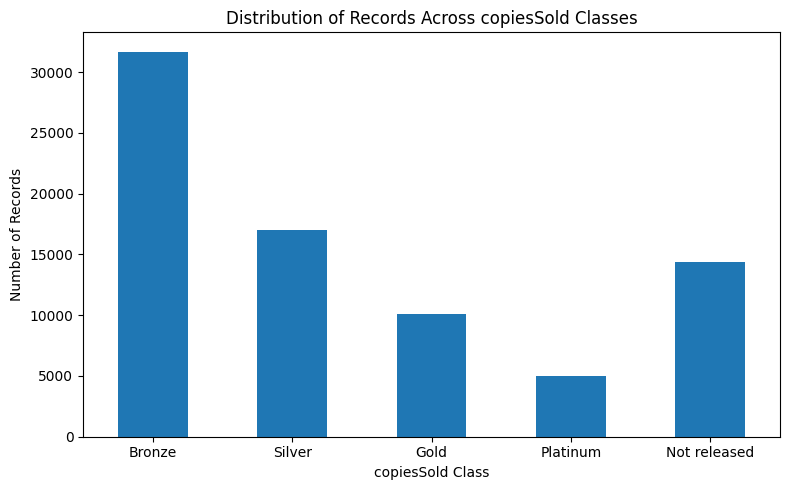

In [227]:
# 2. Create the reverse mapping
inv_map = {
    0: 'Bronze',
    1: 'Silver',
    2: 'Gold',
    3: 'Platinum',
    4: 'Not released'
}

# 3. Rename the index of counts
counts.index = counts.index.map(inv_map)

# 4. Plot with the new labels
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('copiesSold Class')
plt.ylabel('Number of Records')
plt.title('Distribution of Records Across copiesSold Classes')
plt.xticks(rotation=0)    # keep names horizontal
plt.tight_layout()
plt.show()


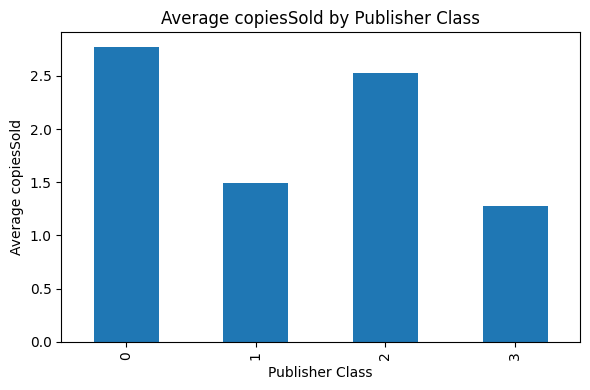

In [228]:
# Example: publisherClass
mean_by_pub = train_df.groupby('publisherClass')['copiesSold'].mean()
mean_by_pub.plot(kind='bar', figsize=(6,4))
plt.xlabel('Publisher Class')
plt.ylabel('Average copiesSold')
plt.title('Average copiesSold by Publisher Class')
plt.tight_layout()
plt.show()


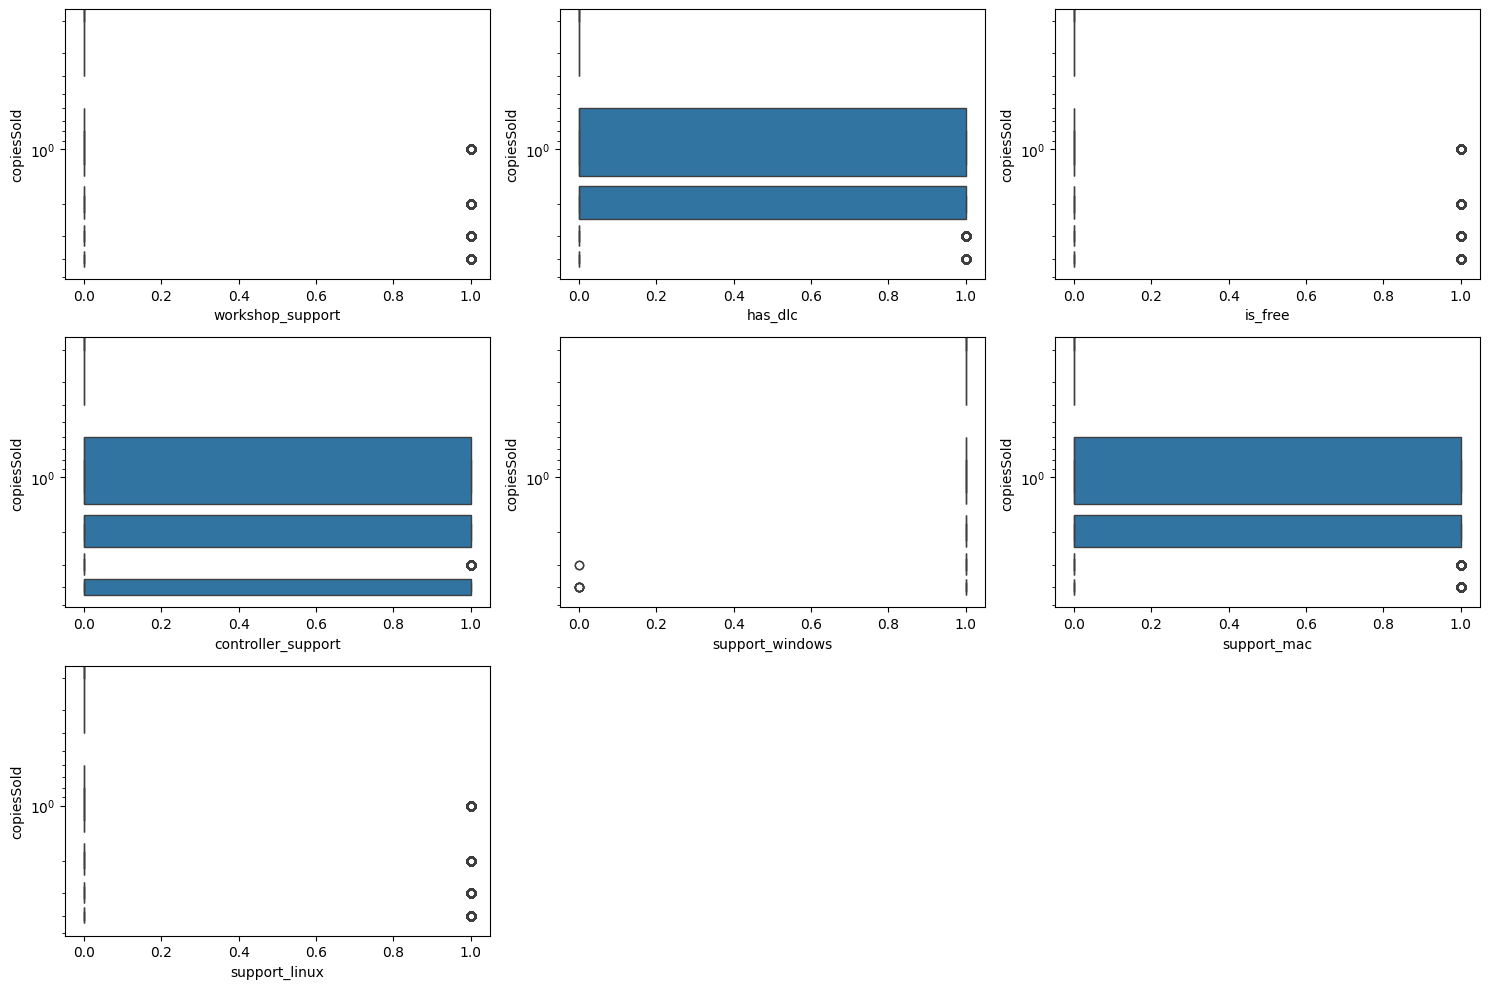

In [229]:
binary_features = ['workshop_support', 'has_dlc', 'is_free',
                  'controller_support', 'support_windows', 'support_mac', 'support_linux']

plt.figure(figsize=(15,10))
for i, feat in enumerate(binary_features, 1):
    plt.subplot(3,3,i)
    sns.boxplot(x=feat, y='copiesSold', data=df)
    plt.yscale('log')  # If sales are skewed
plt.tight_layout()

Text(0.5, 1.0, 'Sales Distribution by Publisher Class')

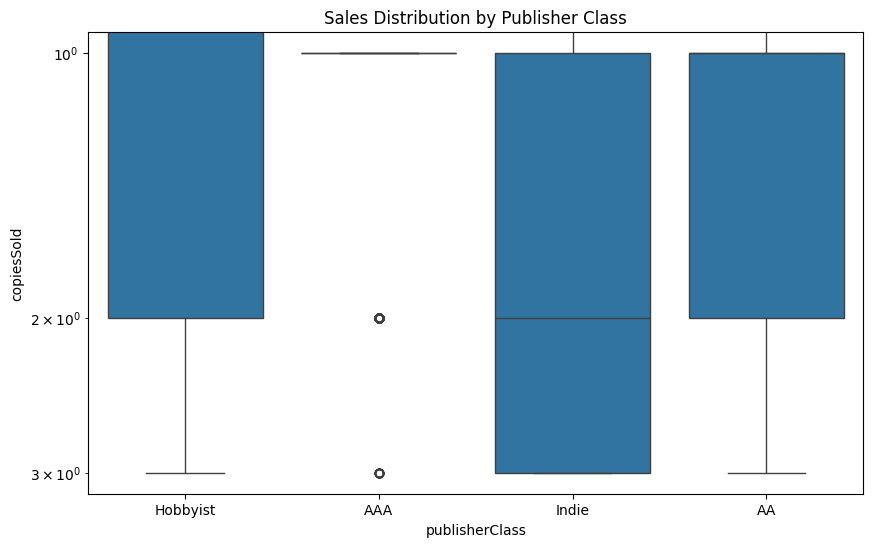

In [230]:
plt.figure(figsize=(10,6))
sns.boxplot(x='publisherClass', y='copiesSold', data=df)
plt.yscale('log')
plt.title('Sales Distribution by Publisher Class')

Text(0.5, 1.0, 'Sales by Number of Supported Platforms')

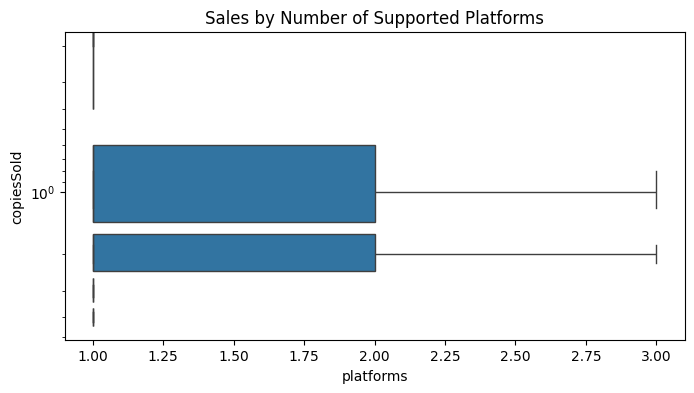

In [231]:
# Create combined platform feature
df['platforms'] = df['support_windows'] + df['support_mac'] + df['support_linux']

plt.figure(figsize=(8,4))
sns.boxplot(x='platforms', y='copiesSold', data=df, showfliers=False)
plt.yscale('log')
plt.title("Sales by Number of Supported Platforms")

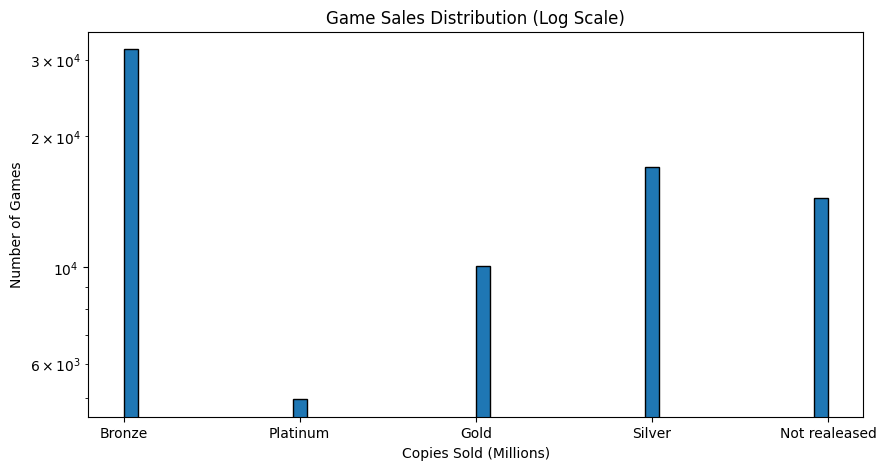

In [232]:
plt.figure(figsize=(10, 5))
plt.hist(df['copiesSold'], bins=50, edgecolor='black', log=True)
plt.title('Game Sales Distribution (Log Scale)')
plt.xlabel('Copies Sold (Millions)')
plt.ylabel('Number of Games')
plt.show()

Text(0, 0.5, '')

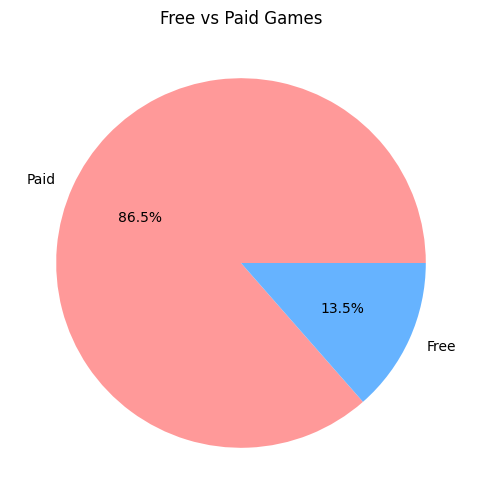

In [233]:
plt.figure(figsize=(6, 6))
df['is_free'].value_counts().plot.pie(autopct='%1.1f%%',
                                    labels=['Paid', 'Free'],
                                    colors=['#ff9999','#66b3ff'])
plt.title('Free vs Paid Games')
plt.ylabel('')

Text(0, 0.5, '')

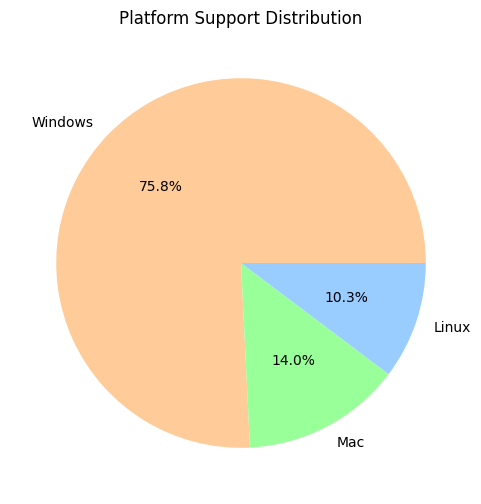

In [234]:
platform_counts = df[['support_windows', 'support_mac', 'support_linux']].sum()
plt.figure(figsize=(6, 6))
platform_counts.plot.pie(autopct='%1.1f%%',
                        labels=['Windows', 'Mac', 'Linux'],
                        colors=['#ffcc99','#99ff99','#99ccff'])
plt.title('Platform Support Distribution')
plt.ylabel('')

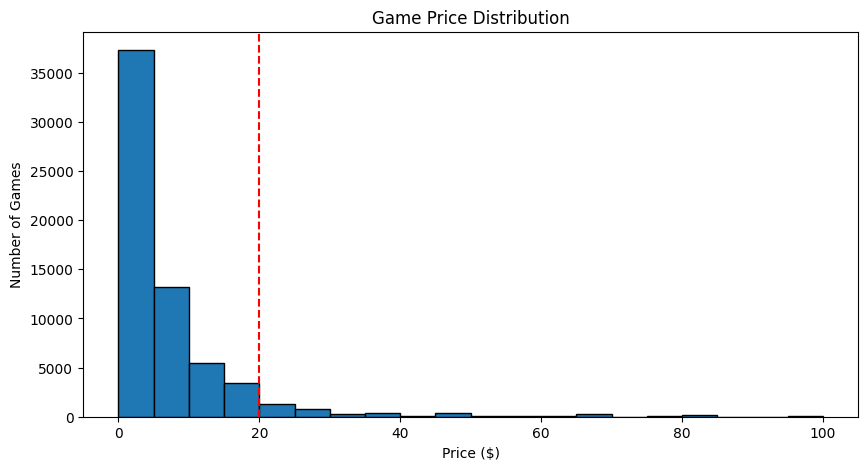

In [235]:
plt.figure(figsize=(10, 5))
plt.hist(df['price'], bins=range(0, 101, 5), edgecolor='black')
plt.title('Game Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Number of Games')
plt.axvline(19.99, color='red', linestyle='--')

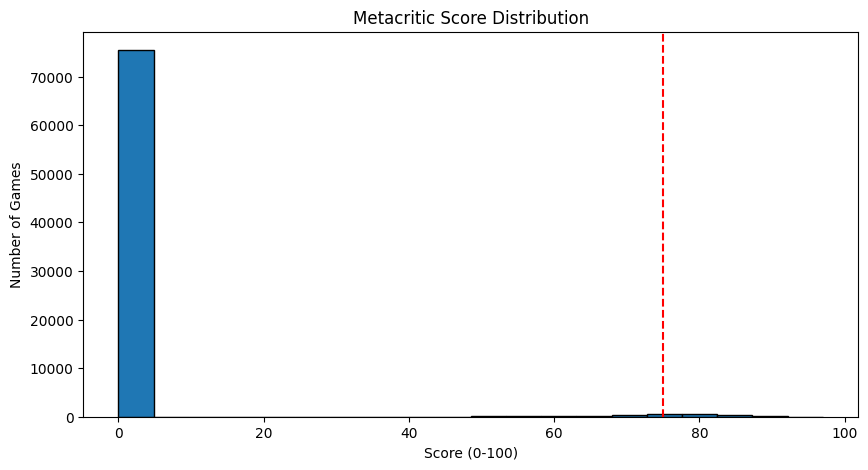

In [236]:
plt.figure(figsize=(10, 5))
plt.hist(df['metacritic'], bins=20, edgecolor='black')
plt.title('Metacritic Score Distribution')
plt.xlabel('Score (0-100)')
plt.ylabel('Number of Games')
plt.axvline(75, color='red', linestyle='--')

Text(0, 0.5, 'Count (Log Scale)')

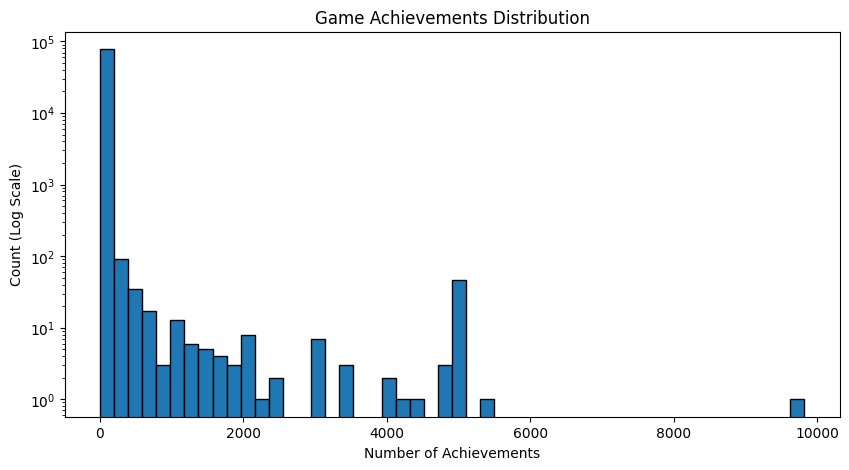

In [237]:
plt.figure(figsize=(10, 5))
plt.hist(df['achievements_total'], bins=50, edgecolor='black', log=True)
plt.title('Game Achievements Distribution')
plt.xlabel('Number of Achievements')
plt.ylabel('Count (Log Scale)')

In [239]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   steam_id               78101 non-null  object 
 1   name_info              78086 non-null  object 
 2   metacritic             78101 non-null  int64  
 3   steam_achievements     78101 non-null  int64  
 4   steam_trading_cards    78101 non-null  int64  
 5   workshop_support       78101 non-null  int64  
 6   genres                 78101 non-null  object 
 7   achievements_total     78101 non-null  int64  
 8   release_date           77953 non-null  object 
 9   coming_soon            78101 non-null  float64
 10  support_windows        78101 non-null  int64  
 11  support_mac            78101 non-null  int64  
 12  support_linux          78101 non-null  int64  
 13  has_dlc                78101 non-null  int64  
 14  has_demo               78101 non-null  int64  
 15  pub

# Modelling

In [96]:
# Combine the dataframes
#combined_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

In [97]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   steam_id               78101 non-null  object 
 1   name_info              78086 non-null  object 
 2   metacritic             78101 non-null  int64  
 3   steam_achievements     78101 non-null  int64  
 4   steam_trading_cards    78101 non-null  int64  
 5   workshop_support       78101 non-null  int64  
 6   genres                 78101 non-null  object 
 7   achievements_total     78101 non-null  int64  
 8   release_date           77953 non-null  object 
 9   coming_soon            78101 non-null  float64
 10  support_windows        78101 non-null  int64  
 11  support_mac            78101 non-null  int64  
 12  support_linux          78101 non-null  int64  
 13  has_dlc                78101 non-null  int64  
 14  has_demo               78101 non-null  int64  
 15  pub

In [98]:
(train_df.isnull().sum()/len(train_df))*100

,0
steam_id,0.000000
name_info,0.019206
metacritic,0.000000
steam_achievements,0.000000
steam_trading_cards,0.000000
workshop_support,0.000000
genres,0.000000
achievements_total,0.000000
release_date,0.189498
coming_soon,0.000000


In [99]:
columns_to_drop = ['steam_id', 'name_info', 'publisher', 'developer','languages_clean_str', 'standardized_date','categories','genres','release_date']

In [166]:
train_df=train_df.drop(columns=columns_to_drop)
val_df=val_df.drop(columns=columns_to_drop)
test_df=test_df.drop(columns=columns_to_drop)

In [101]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   metacritic             78101 non-null  int64  
 1   steam_achievements     78101 non-null  int64  
 2   steam_trading_cards    78101 non-null  int64  
 3   workshop_support       78101 non-null  int64  
 4   achievements_total     78101 non-null  int64  
 5   coming_soon            78101 non-null  float64
 6   support_windows        78101 non-null  int64  
 7   support_mac            78101 non-null  int64  
 8   support_linux          78101 non-null  int64  
 9   has_dlc                78101 non-null  int64  
 10  has_demo               78101 non-null  int64  
 11  is_free                78101 non-null  int64  
 12  controller_support     78101 non-null  int64  
 13  recommendations        78101 non-null  int64  
 14  age_rating             78101 non-null  int64  
 15  pri

In [102]:
train_df.shape

(78101, 29)

In [103]:
train_df.head()

,metacritic,steam_achievements,steam_trading_cards,workshop_support,achievements_total,coming_soon,support_windows,support_mac,support_linux,has_dlc,...,total_languages,Casual & Social Games,Core Games,Creative Tools,Education & Training,Indie,Mature Content,Productivity Tools,Sports & Racing,Uncategorized
16900,0,0,0,0,0,0.0,1,1,1,0,...,1,1,0,0,0,1,0,0,0,0
49562,0,1,0,0,48,0.0,1,0,0,0,...,2,0,1,0,0,0,0,0,0,0
79093,0,0,0,0,0,0.0,1,0,0,0,...,2,0,1,0,0,1,0,0,0,0
48319,0,1,1,0,23,0.0,1,0,0,0,...,25,1,1,0,0,0,0,0,0,0
97798,0,1,0,0,12,0.0,1,0,1,0,...,1,1,0,0,0,1,0,0,0,0


In [104]:
print((train_df.isnull().sum()/len(train_df))*100)


metacritic               0.0
steam_achievements       0.0
steam_trading_cards      0.0
workshop_support         0.0
achievements_total       0.0
coming_soon              0.0
support_windows          0.0
support_mac              0.0
support_linux            0.0
has_dlc                  0.0
has_demo                 0.0
is_free                  0.0
controller_support       0.0
recommendations          0.0
age_rating               0.0
price                    0.0
copiesSold               0.0
reviewScore              0.0
publisherClass           0.0
total_languages          0.0
Casual & Social Games    0.0
Core Games               0.0
Creative Tools           0.0
Education & Training     0.0
Indie                    0.0
Mature Content           0.0
Productivity Tools       0.0
Sports & Racing          0.0
Uncategorized            0.0
dtype: float64


In [105]:
X_train = train_df.drop(columns=['copiesSold'])
y_train = train_df['copiesSold']

X_val = val_df.drop(columns=['copiesSold'])
y_val = val_df['copiesSold']

X_test = test_df.drop(columns=['copiesSold'])
y_test = test_df['copiesSold']


In [106]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   metacritic             78101 non-null  int64  
 1   steam_achievements     78101 non-null  int64  
 2   steam_trading_cards    78101 non-null  int64  
 3   workshop_support       78101 non-null  int64  
 4   achievements_total     78101 non-null  int64  
 5   coming_soon            78101 non-null  float64
 6   support_windows        78101 non-null  int64  
 7   support_mac            78101 non-null  int64  
 8   support_linux          78101 non-null  int64  
 9   has_dlc                78101 non-null  int64  
 10  has_demo               78101 non-null  int64  
 11  is_free                78101 non-null  int64  
 12  controller_support     78101 non-null  int64  
 13  recommendations        78101 non-null  int64  
 14  age_rating             78101 non-null  int64  
 15  pri

In [107]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [108]:
y_train_pred = rf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f" Train Accuracy: {train_acc:.4f}")

y_val_pred = rf.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f" Validation Accuracy: {val_acc:.4f}")

y_test_pred = rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f" Test Accuracy: {test_acc:.4f}")

 Train Accuracy: 0.8316
 Validation Accuracy: 0.8105
 Test Accuracy: 0.8018


In [109]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_val_pred = xgb.predict(X_val)
y_test_pred = xgb.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.8389
Validation Accuracy: 0.8243
Test Accuracy: 0.8147


In [110]:
# Initialize CatBoost model
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    eval_metric='Accuracy',
    verbose=False
)

# Fit model
cat_model.fit(X_train, y_train, cat_features=[], eval_set=(X_val, y_val))

# Predictions
y_train_pred = cat_model.predict(X_train)
y_val_pred = cat_model.predict(X_val)
y_test_pred = cat_model.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.8171
Validation Accuracy: 0.8154
Test Accuracy: 0.8073


In [111]:
# Define the MLP model
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Fit the model
mlp.fit(X_train, y_train)

# Predict on each set
y_train_pred = mlp.predict(X_train)
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

# Print accuracies
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


Train Accuracy: 0.8003
Validation Accuracy: 0.7988
Test Accuracy: 0.7911


In [112]:
# Optional but recommended: Scale your features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression
logreg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    random_state=42
)

# Fit the model
logreg.fit(X_train_scaled, y_train)

# Predict
y_train_pred = logreg.predict(X_train_scaled)
y_val_pred = logreg.predict(X_val_scaled)
y_test_pred = logreg.predict(X_test_scaled)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.7227
Validation Accuracy: 0.7257
Test Accuracy: 0.7180


In [113]:
# Fixed hyperparameters
fixed_params = {
    'min_samples_split': 5,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'random_state': 42
}

# Hyperparameter values
n_estimators_values = [50, 200, 500]
max_depth_values = [10, 12, 15]

# Containers
model_names = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_times = []
test_times = []

# Helper function for training & evaluation
def train_and_evaluate(model_name, **rf_params):
    model_names.append(model_name)

    # Timing training
    start_train = time.time()
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)
    end_train = time.time()

    # Timing prediction
    start_test = time.time()
    y_pred_train = rf.predict(X_train)
    y_pred_val = rf.predict(X_val)
    y_pred_test = rf.predict(X_test)
    end_test = time.time()

    # Accuracy
    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    val_accuracies.append(accuracy_score(y_val, y_pred_val))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

    # Time
    train_times.append(end_train - start_train)
    test_times.append(end_test - start_test)

# Models with varying n_estimators
for n in n_estimators_values:
    train_and_evaluate(f'n_estimators={n}', n_estimators=n, max_depth=15, **fixed_params)

# Models with varying max_depth
for d in max_depth_values:
    train_and_evaluate(f'max_depth={d}', n_estimators=200, max_depth=d, **fixed_params)

In [114]:
# Combine everything in a table
summary = []
for i in range(len(model_names)):
    summary.append([
        model_names[i],
        f"{train_accuracies[i]:.4f}",
        f"{val_accuracies[i]:.4f}",
        f"{test_accuracies[i]:.4f}",
        f"{train_times[i]:.4f} sec",
        f"{test_times[i]:.4f} sec"
    ])

# Define headers
headers = ['Model', 'Train Acc', 'Val Acc', 'Test Acc', 'Train Time', 'Test Time']

# Print table
print(tabulate(summary, headers=headers, tablefmt='pretty'))


+------------------+-----------+---------+----------+-------------+------------+
|      Model       | Train Acc | Val Acc | Test Acc | Train Time  | Test Time  |
+------------------+-----------+---------+----------+-------------+------------+
| n_estimators=50  |  0.8318   | 0.8101  |  0.8019  | 3.5978 sec  | 1.0648 sec |
| n_estimators=200 |  0.8316   | 0.8105  |  0.8018  | 13.0853 sec | 3.7444 sec |
| n_estimators=500 |  0.8319   | 0.8109  |  0.8024  | 34.1384 sec | 8.7840 sec |
|   max_depth=10   |  0.8055   | 0.7979  |  0.7926  | 10.1560 sec | 2.4343 sec |
|   max_depth=12   |  0.8169   | 0.8056  |  0.7989  | 11.5685 sec | 2.7586 sec |
|   max_depth=15   |  0.8316   | 0.8105  |  0.8018  | 13.5912 sec | 3.0133 sec |
+------------------+-----------+---------+----------+-------------+------------+


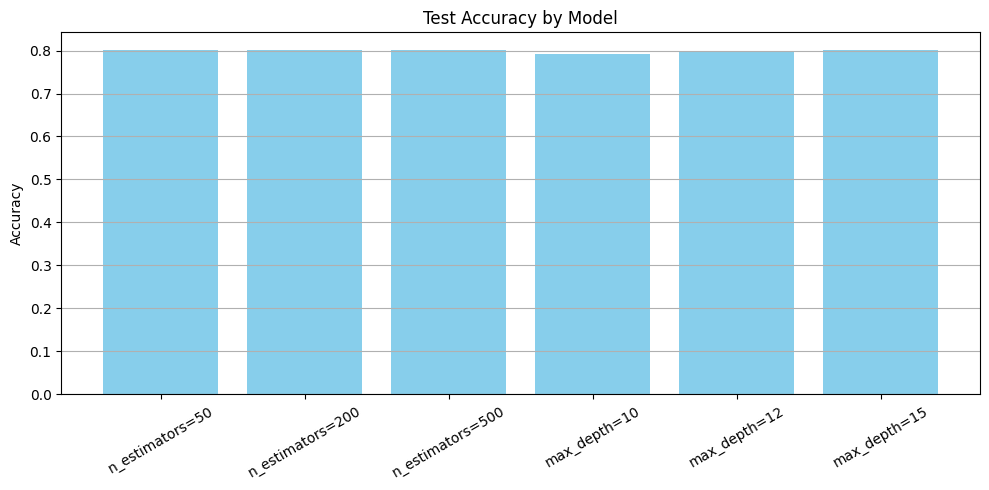

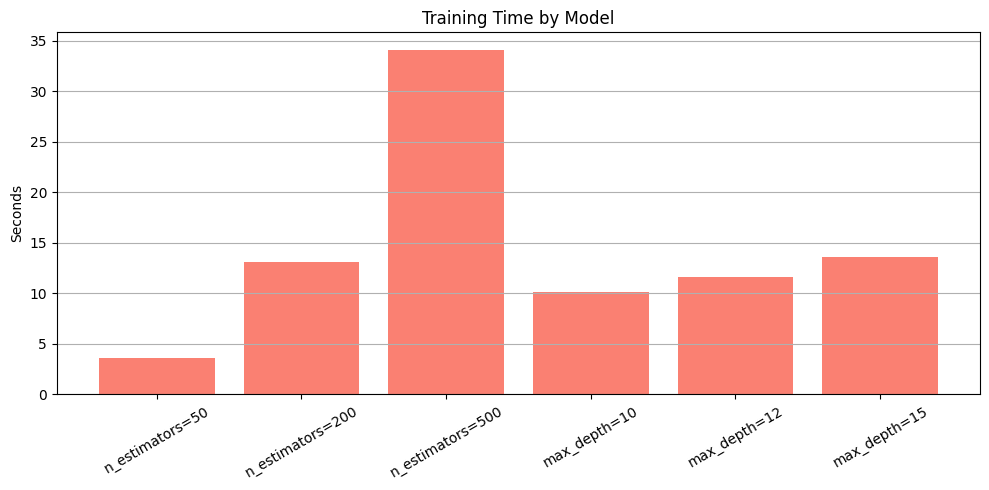

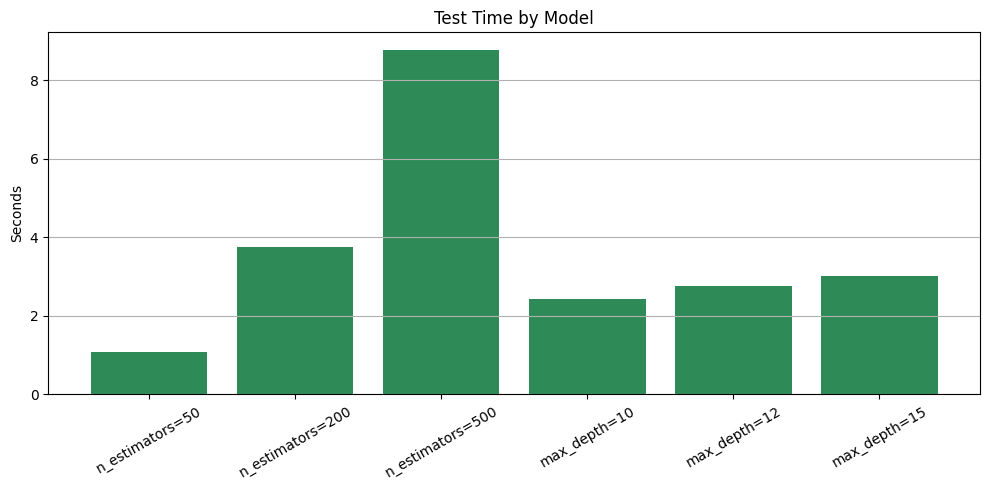

In [115]:
# Plotting
def plot_bar(values, title, ylabel, color, rotation=30):
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, values, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Plot accuracy bars (you can average all or just show test)
plot_bar(test_accuracies, 'Test Accuracy by Model', 'Accuracy', color='skyblue')
plot_bar(train_times, 'Training Time by Model', 'Seconds', color='salmon')
plot_bar(test_times, 'Test Time by Model', 'Seconds', color='seagreen')

In [116]:
# Fixed params except the one we vary
base_params = dict(
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric='mlogloss',
    random_state=42,
)

# --------------------------
# Study n_estimators
n_estimators_values = [100, 300, 500]
results_n_estimators = {'train': [], 'val': [], 'test': []}
train_times_n = []
test_times_n = []

for n in n_estimators_values:
    model = XGBClassifier(n_estimators=n, max_depth=6, **base_params)

    start_train = time.time()
    model.fit(X_train, y_train)
    train_times_n.append(time.time() - start_train)

    start_test = time.time()
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    test_times_n.append(time.time() - start_test)

    results_n_estimators['train'].append(accuracy_score(y_train, y_train_pred))
    results_n_estimators['val'].append(accuracy_score(y_val, y_val_pred))
    results_n_estimators['test'].append(accuracy_score(y_test, y_test_pred))

# --------------------------
# Study max_depth
max_depth_values = [3, 6, 10]
results_max_depth = {'train': [], 'val': [], 'test': []}
train_times_d = []
test_times_d = []

for d in max_depth_values:
    model = XGBClassifier(n_estimators=300, max_depth=d, **base_params)

    start_train = time.time()
    model.fit(X_train, y_train)
    train_times_d.append(time.time() - start_train)

    start_test = time.time()
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    test_times_d.append(time.time() - start_test)

    results_max_depth['train'].append(accuracy_score(y_train, y_train_pred))
    results_max_depth['val'].append(accuracy_score(y_val, y_val_pred))
    results_max_depth['test'].append(accuracy_score(y_test, y_test_pred))


In [117]:
# Function to print summary tables
def print_summary_table(model_names, results, train_times, test_times, title):
    summary = []
    for i in range(len(model_names)):
        summary.append([
            model_names[i],
            f"{results['train'][i]:.4f}",
            f"{results['val'][i]:.4f}",
            f"{results['test'][i]:.4f}",
            f"{train_times[i]:.4f} sec",
            f"{test_times[i]:.4f} sec"
        ])

    headers = ['Model', 'Train Acc', 'Val Acc', 'Test Acc', 'Train Time', 'Test Time']
    print(f"\n{title}\n")
    print(tabulate(summary, headers=headers, tablefmt='pretty'))

# Print tables
print_summary_table(
    [f"n_estimators={n}" for n in n_estimators_values],
    results_n_estimators, train_times_n, test_times_n,
    title="XGBClassifier Tuning: n_estimators"
)

print_summary_table(
    [f"max_depth={d}" for d in max_depth_values],
    results_max_depth, train_times_d, test_times_d,
    title="XGBClassifier Tuning: max_depth"
)


XGBClassifier Tuning: n_estimators

+------------------+-----------+---------+----------+-------------+------------+
|      Model       | Train Acc | Val Acc | Test Acc | Train Time  | Test Time  |
+------------------+-----------+---------+----------+-------------+------------+
| n_estimators=100 |  0.8160   | 0.8144  |  0.8040  | 4.6046 sec  | 1.5486 sec |
| n_estimators=300 |  0.8389   | 0.8243  |  0.8147  | 18.9409 sec | 3.0936 sec |
| n_estimators=500 |  0.8540   | 0.8277  |  0.8185  | 30.5252 sec | 7.7138 sec |
+------------------+-----------+---------+----------+-------------+------------+

XGBClassifier Tuning: max_depth

+--------------+-----------+---------+----------+-------------+------------+
|    Model     | Train Acc | Val Acc | Test Acc | Train Time  | Test Time  |
+--------------+-----------+---------+----------+-------------+------------+
| max_depth=3  |  0.8126   | 0.8125  |  0.8026  | 15.5984 sec | 1.4418 sec |
| max_depth=6  |  0.8389   | 0.8243  |  0.8147  | 16.6

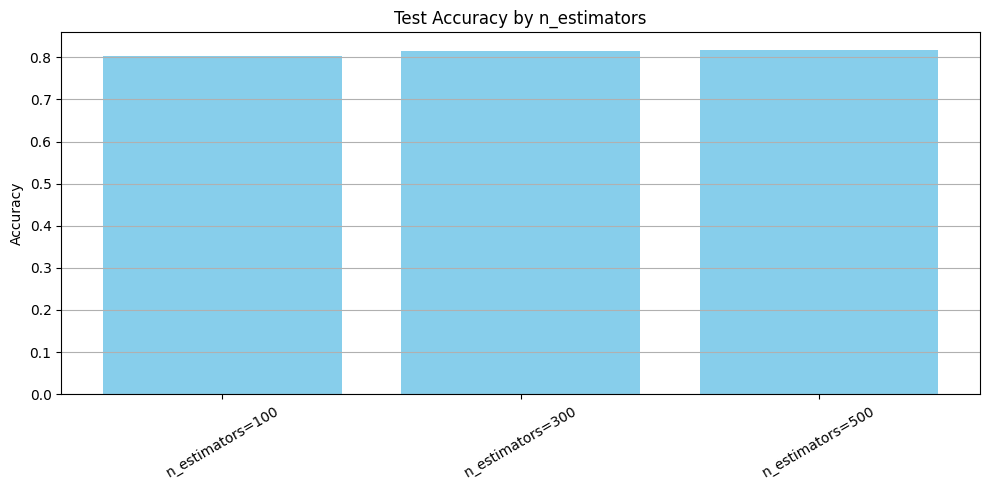

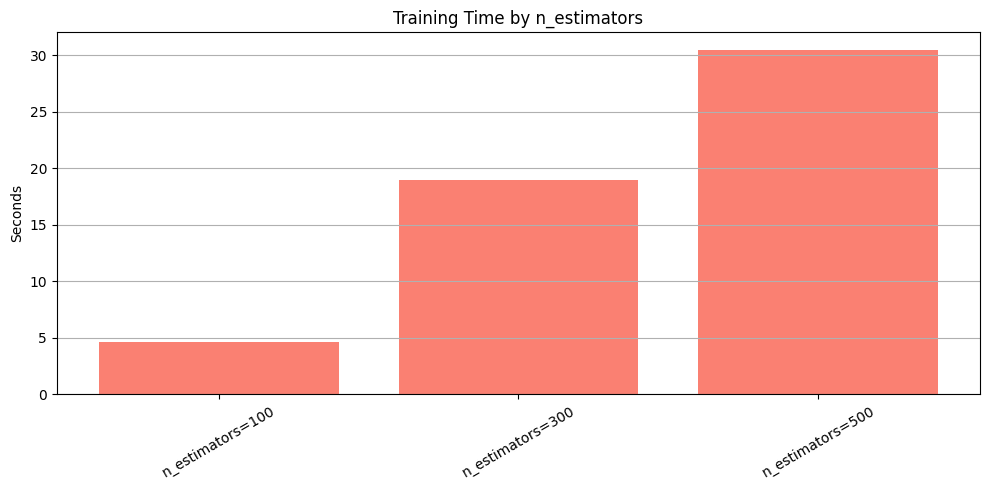

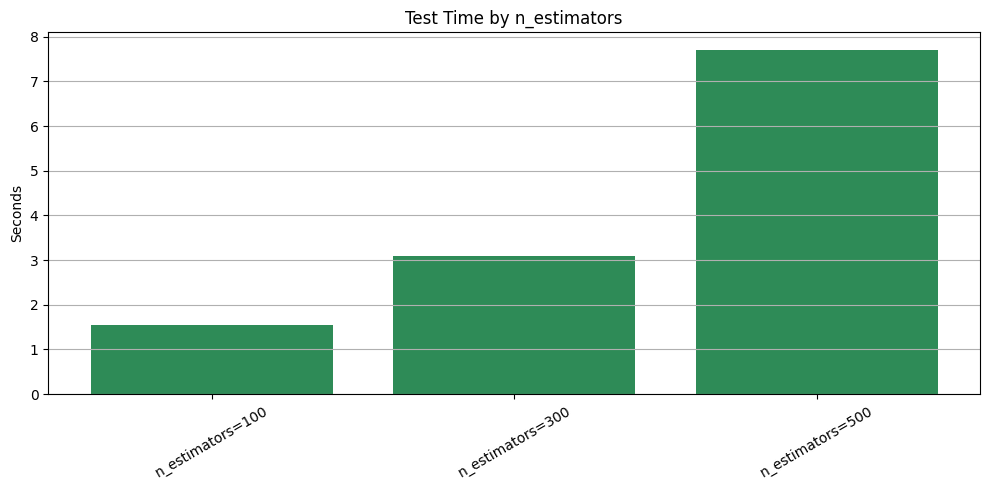

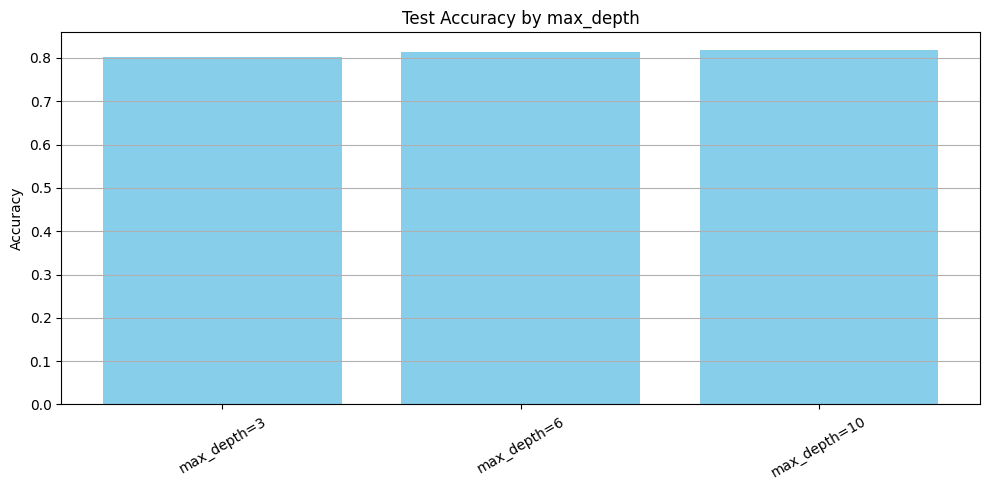

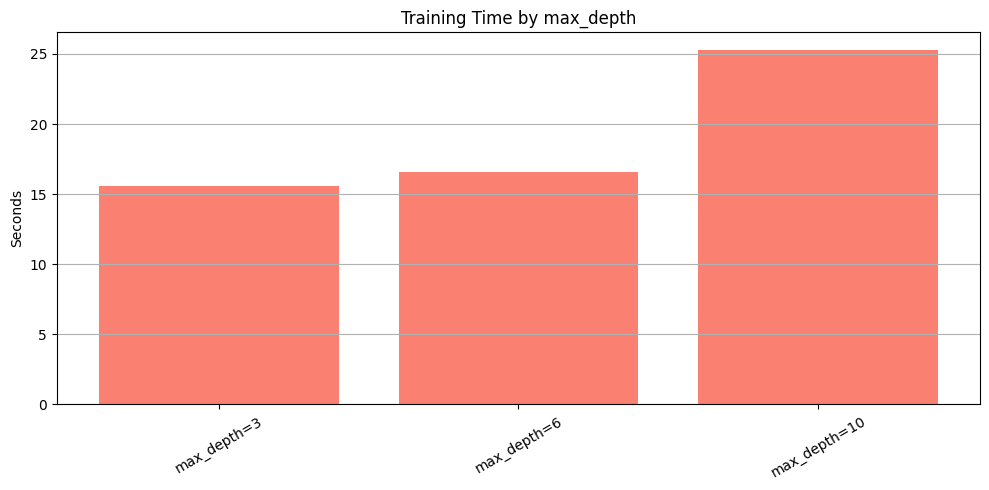

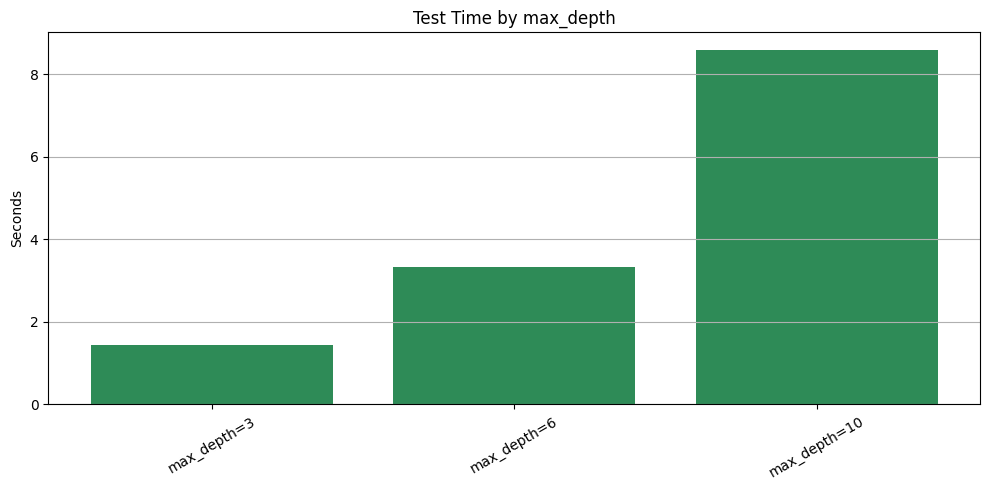

In [118]:
# Plotting function
def plot_bar(values, title, ylabel, color, rotation=30):
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, values, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Plot for n_estimators tuning
model_names = [f"n_estimators={n}" for n in n_estimators_values]

plot_bar(results_n_estimators['test'], 'Test Accuracy by n_estimators', 'Accuracy', color='skyblue')
plot_bar(train_times_n, 'Training Time by n_estimators', 'Seconds', color='salmon')
plot_bar(test_times_n, 'Test Time by n_estimators', 'Seconds', color='seagreen')

# Plot for max_depth tuning
model_names = [f"max_depth={d}" for d in max_depth_values]

plot_bar(results_max_depth['test'], 'Test Accuracy by max_depth', 'Accuracy', color='skyblue')
plot_bar(train_times_d, 'Training Time by max_depth', 'Seconds', color='salmon')
plot_bar(test_times_d, 'Test Time by max_depth', 'Seconds', color='seagreen')

In [119]:
# Fixed params except the one we vary
base_params = dict(
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=42,
    eval_metric='Accuracy',
    verbose=False
)

# Vary iterations
iterations_values = [100, 300, 500]
results_iterations = {'train': [], 'val': [], 'test': []}
train_times_iter = []
test_times_iter = []

for iters in iterations_values:
    model = CatBoostClassifier(iterations=iters, depth=6, **base_params)

    start_train = time.time()
    model.fit(X_train, y_train)
    train_times_iter.append(time.time() - start_train)

    start_test = time.time()
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    test_times_iter.append(time.time() - start_test)

    results_iterations['train'].append(accuracy_score(y_train, y_train_pred))
    results_iterations['val'].append(accuracy_score(y_val, y_val_pred))
    results_iterations['test'].append(accuracy_score(y_test, y_test_pred))

# Vary depth
depth_values = [4, 6, 10]
results_depth = {'train': [], 'val': [], 'test': []}
train_times_depth = []
test_times_depth = []

for d in depth_values:
    model = CatBoostClassifier(iterations=300, depth=d, **base_params)

    start_train = time.time()
    model.fit(X_train, y_train)
    train_times_depth.append(time.time() - start_train)

    start_test = time.time()
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    test_times_depth.append(time.time() - start_test)

    results_depth['train'].append(accuracy_score(y_train, y_train_pred))
    results_depth['val'].append(accuracy_score(y_val, y_val_pred))
    results_depth['test'].append(accuracy_score(y_test, y_test_pred))


In [120]:
# Print summary tables
def print_summary_table(model_names, results, train_times, test_times, title):
    summary = []
    for i in range(len(model_names)):
        summary.append([
            model_names[i],
            f"{results['train'][i]:.4f}",
            f"{results['val'][i]:.4f}",
            f"{results['test'][i]:.4f}",
            f"{train_times[i]:.4f} sec",
            f"{test_times[i]:.4f} sec"
        ])
    headers = ['Model', 'Train Acc', 'Val Acc', 'Test Acc', 'Train Time', 'Test Time']
    print(f"\n{title}\n")
    print(tabulate(summary, headers=headers, tablefmt='pretty'))

print_summary_table(
    [f"iterations={i}" for i in iterations_values],
    results_iterations,
    train_times_iter,
    test_times_iter,
    title="CatBoost Tuning: iterations"
)

print_summary_table(
    [f"depth={d}" for d in depth_values],
    results_depth,
    train_times_depth,
    test_times_depth,
    title="CatBoost Tuning: depth"
)



CatBoost Tuning: iterations

+----------------+-----------+---------+----------+-------------+------------+
|     Model      | Train Acc | Val Acc | Test Acc | Train Time  | Test Time  |
+----------------+-----------+---------+----------+-------------+------------+
| iterations=100 |  0.8020   | 0.8053  |  0.7944  | 5.6350 sec  | 0.1288 sec |
| iterations=300 |  0.8186   | 0.8153  |  0.8080  | 20.5894 sec | 0.1847 sec |
| iterations=500 |  0.8274   | 0.8201  |  0.8121  | 31.6673 sec | 0.3314 sec |
+----------------+-----------+---------+----------+-------------+------------+

CatBoost Tuning: depth

+----------+-----------+---------+----------+--------------+------------+
|  Model   | Train Acc | Val Acc | Test Acc |  Train Time  | Test Time  |
+----------+-----------+---------+----------+--------------+------------+
| depth=4  |  0.8110   | 0.8117  |  0.8017  | 14.8728 sec  | 0.1801 sec |
| depth=6  |  0.8186   | 0.8153  |  0.8080  | 18.7156 sec  | 0.1866 sec |
| depth=10 |  0.8401  

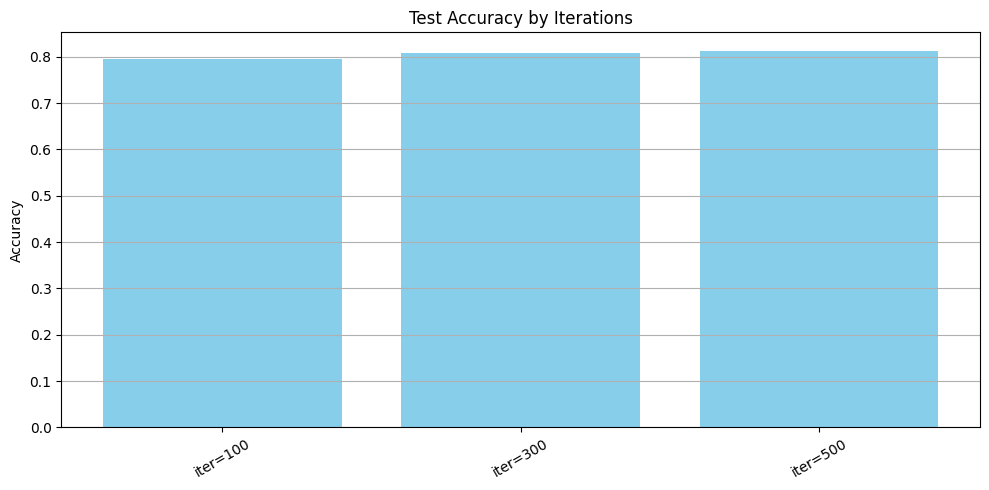

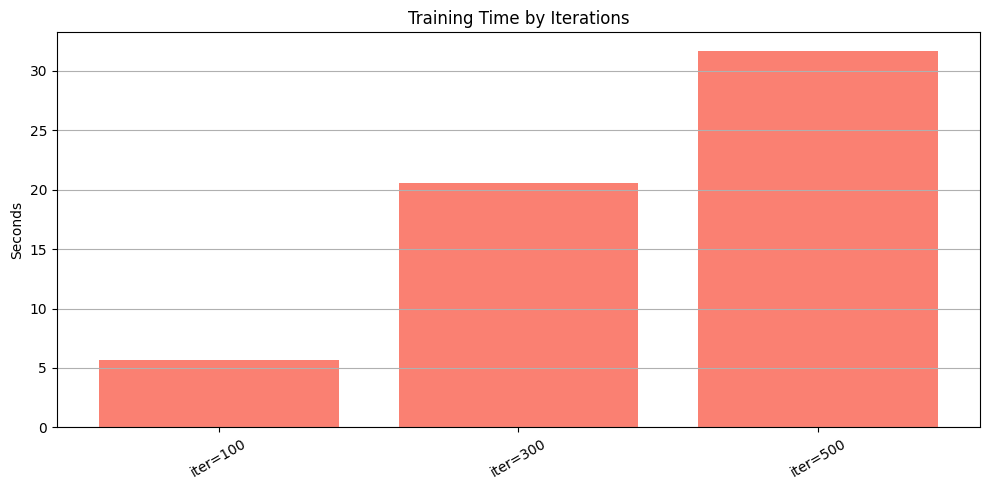

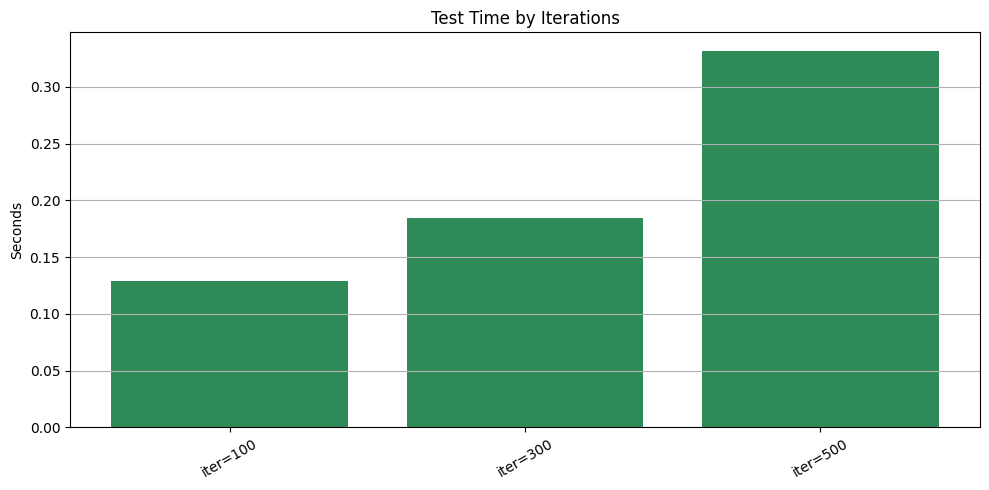

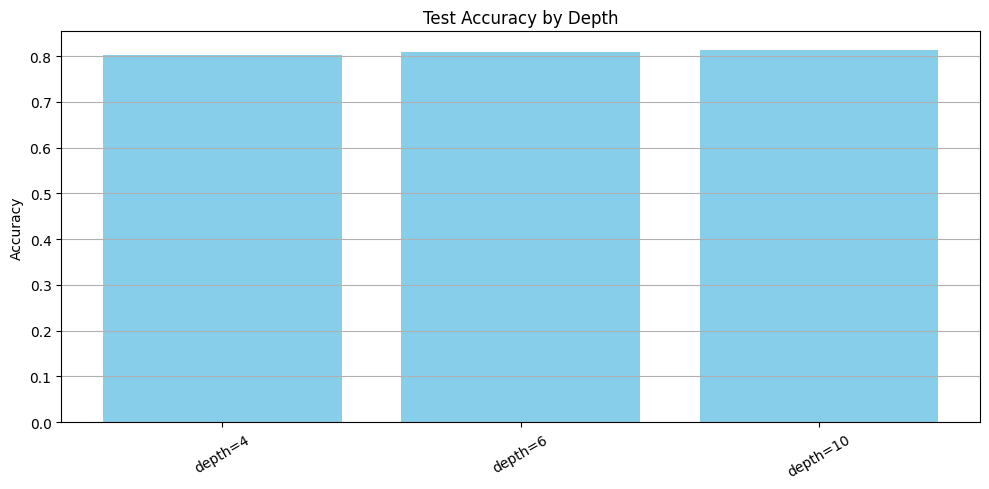

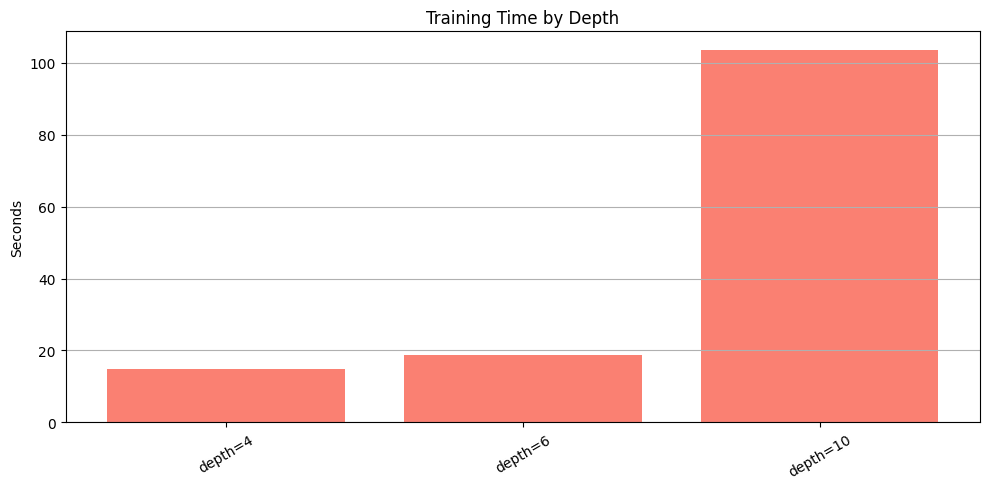

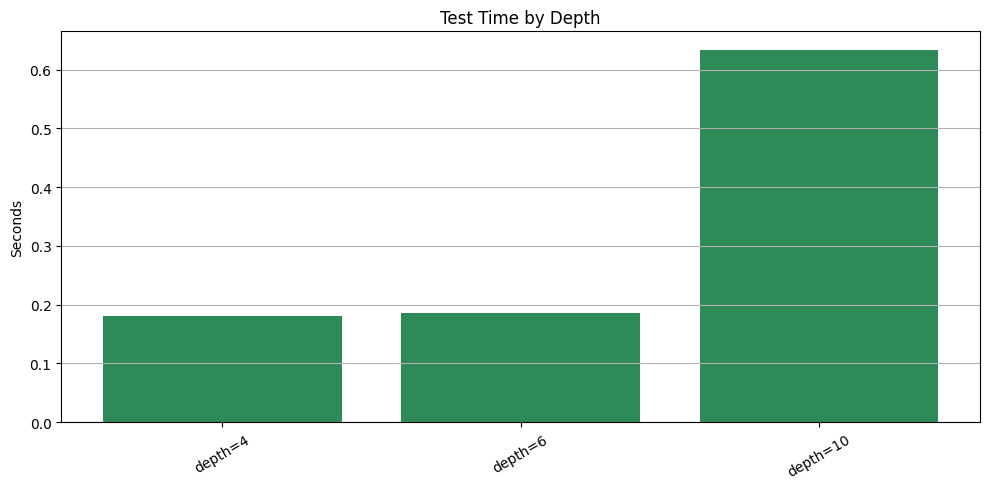

In [121]:
# Plotting function
def plot_bar(values, title, ylabel, color, rotation=30):
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, values, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Plot for iterations
model_names = [f"iter={i}" for i in iterations_values]

plot_bar(results_iterations['test'], 'Test Accuracy by Iterations', 'Accuracy', color='skyblue')
plot_bar(train_times_iter, 'Training Time by Iterations', 'Seconds', color='salmon')
plot_bar(test_times_iter, 'Test Time by Iterations', 'Seconds', color='seagreen')

# Plot for depth
model_names = [f"depth={d}" for d in depth_values]

plot_bar(results_depth['test'], 'Test Accuracy by Depth', 'Accuracy', color='skyblue')
plot_bar(train_times_depth, 'Training Time by Depth', 'Seconds', color='salmon')
plot_bar(test_times_depth, 'Test Time by Depth', 'Seconds', color='seagreen')

In [122]:
# Fixed hyperparameters
fixed_params = {
    'activation': 'relu',
    'solver': 'adam',
    'random_state': 42,
    'early_stopping': True,
    'validation_fraction': 0.1
}

# Hyperparameter values to vary
hidden_layer_sizes_values = [(128, 64), (256, 128), (64, 32)]
max_iter_values = [200, 300, 400]

# Containers
model_names = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_times = []
test_times = []

# Helper function for training & evaluation
def train_and_evaluate(model_name, **mlp_params):
    model_names.append(model_name)

    start_train = time.time()
    mlp = MLPClassifier(**mlp_params)
    mlp.fit(X_train, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred_train = mlp.predict(X_train)
    y_pred_val = mlp.predict(X_val)
    y_pred_test = mlp.predict(X_test)
    end_test = time.time()

    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    val_accuracies.append(accuracy_score(y_val, y_pred_val))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

    train_times.append(end_train - start_train)
    test_times.append(end_test - start_test)

In [123]:

# Models with varying hidden_layer_sizes
for hls in hidden_layer_sizes_values:
    train_and_evaluate(f'hidden_layer_sizes={hls}', hidden_layer_sizes=hls, max_iter=300, **fixed_params)

# Models with varying max_iter (fix hidden_layer_sizes for this loop)
for mi in max_iter_values:
    train_and_evaluate(f'max_iter={mi}', hidden_layer_sizes=(128, 64), max_iter=mi, **fixed_params)

# Combine everything in a table
summary = []
for i in range(len(model_names)):
    summary.append([
        model_names[i],
        f"{train_accuracies[i]:.4f}",
        f"{val_accuracies[i]:.4f}",
        f"{test_accuracies[i]:.4f}",
        f"{train_times[i]:.4f} sec",
        f"{test_times[i]:.4f} sec"
    ])

headers = ['Model', 'Train Acc', 'Val Acc', 'Test Acc', 'Train Time', 'Test Time']

print("MLPClassifier Tuning: hidden_layer_sizes , max_iter ")
print(tabulate(summary, headers=headers, tablefmt='pretty'))


MLPClassifier Tuning: hidden_layer_sizes , max_iter 
+-------------------------------+-----------+---------+----------+--------------+------------+
|             Model             | Train Acc | Val Acc | Test Acc |  Train Time  | Test Time  |
+-------------------------------+-----------+---------+----------+--------------+------------+
| hidden_layer_sizes=(128, 64)  |  0.8003   | 0.7988  |  0.7911  | 91.9492 sec  | 0.5476 sec |
| hidden_layer_sizes=(256, 128) |  0.8075   | 0.7997  |  0.7922  | 166.2398 sec | 1.0513 sec |
|  hidden_layer_sizes=(64, 32)  |  0.7880   | 0.7863  |  0.7823  | 20.1674 sec  | 0.1522 sec |
|         max_iter=200          |  0.8003   | 0.7988  |  0.7911  | 87.7312 sec  | 0.5136 sec |
|         max_iter=300          |  0.8003   | 0.7988  |  0.7911  | 88.2883 sec  | 0.5381 sec |
|         max_iter=400          |  0.8003   | 0.7988  |  0.7911  | 88.4032 sec  | 0.5145 sec |
+-------------------------------+-----------+---------+----------+--------------+-----------

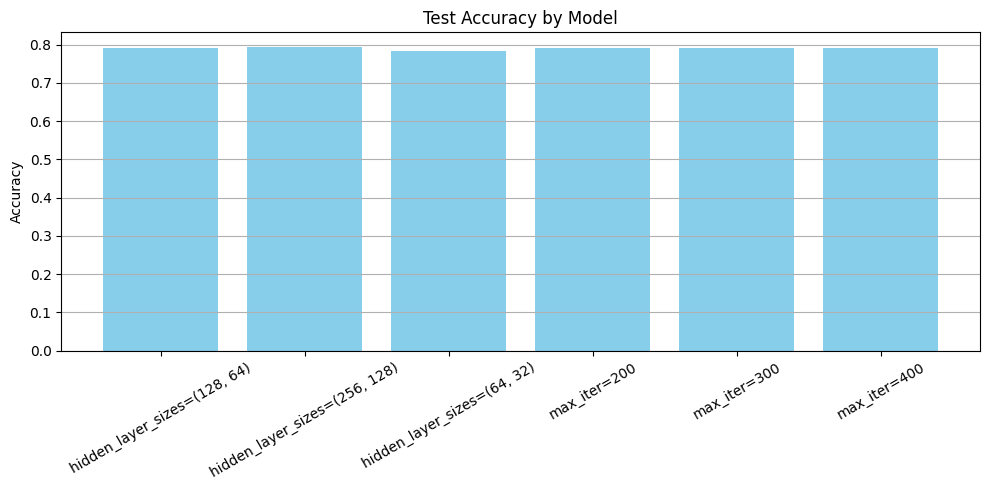

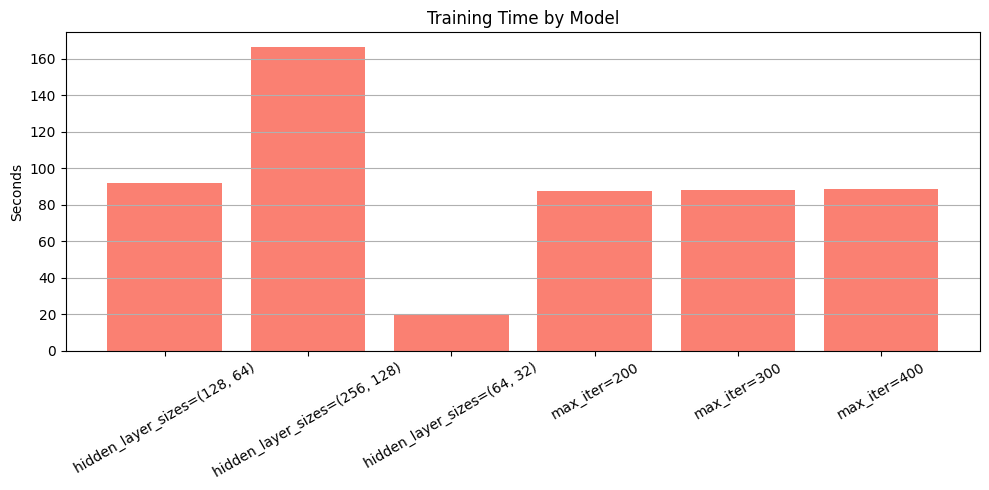

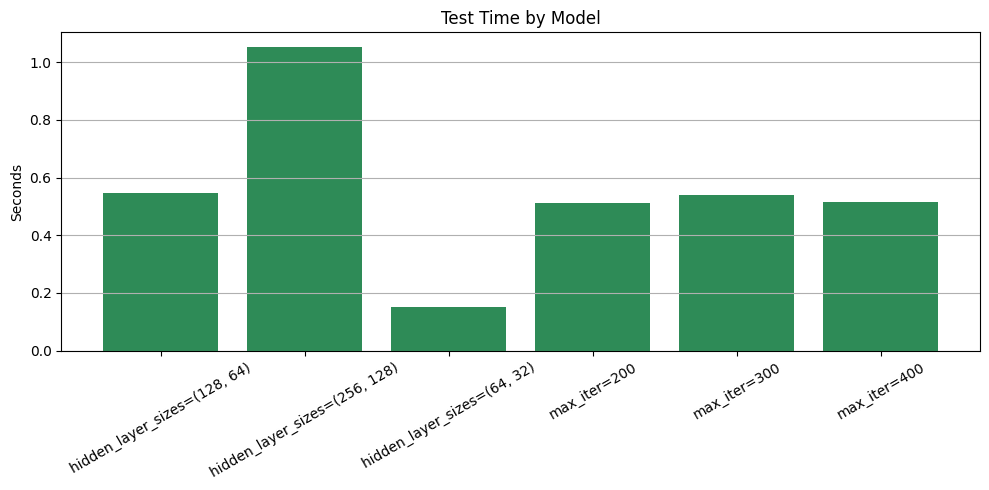

In [124]:
# Plotting function
def plot_bar(values, title, ylabel, color, rotation=30):
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, values, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

plot_bar(test_accuracies, 'Test Accuracy by Model', 'Accuracy', color='skyblue')
plot_bar(train_times, 'Training Time by Model', 'Seconds', color='salmon')
plot_bar(test_times, 'Test Time by Model', 'Seconds', color='seagreen')

In [125]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   metacritic             78101 non-null  int64  
 1   steam_achievements     78101 non-null  int64  
 2   steam_trading_cards    78101 non-null  int64  
 3   workshop_support       78101 non-null  int64  
 4   achievements_total     78101 non-null  int64  
 5   coming_soon            78101 non-null  float64
 6   support_windows        78101 non-null  int64  
 7   support_mac            78101 non-null  int64  
 8   support_linux          78101 non-null  int64  
 9   has_dlc                78101 non-null  int64  
 10  has_demo               78101 non-null  int64  
 11  is_free                78101 non-null  int64  
 12  controller_support     78101 non-null  int64  
 13  recommendations        78101 non-null  int64  
 14  age_rating             78101 non-null  int64  
 15  pri

In [175]:
selected_features = [
    'achievements_total', 'coming_soon',
    'has_dlc',  'metacritic', 'recommendations', 'reviewScore',
    'steam_trading_cards', 'workshop_support'
]

columns_to_drop = ['copiesSold', 'steam_id', 'name_info', 'publisher', 'developer',
                'languages_clean_str', 'genres', 'release_date']

# Training set
#X_train = train_df.drop(columns=columns_to_drop)
X_train = train_df[selected_features]
#y_train = train_df['copiesSold']


#X_val = val_df.drop(columns=columns_to_drop)
X_val = val_df[selected_features]
#y_val = val_df['copiesSold']

#X_test = test_df.drop(columns=columns_to_drop)
X_test = test_df[selected_features]
#y_test = test_df['copiesSold']

In [177]:
# Define the MLP model
mlp_2 = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Fit the model
mlp_2.fit(X_train, y_train)

# Predict on each set
y_train_pred = mlp_2.predict(X_train)
y_val_pred = mlp_2.predict(X_val)
y_test_pred = mlp_2.predict(X_test)

# Print accuracies
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.7364
Validation Accuracy: 0.7414
Test Accuracy: 0.7266


In [178]:
(train_df.isnull().sum()/len(train_df))*100

,0
metacritic,0.000000
steam_achievements,0.000000
steam_trading_cards,0.000000
workshop_support,0.000000
achievements_total,0.000000
coming_soon,0.000000
support_windows,0.000000
support_mac,0.000000
support_linux,0.000000
has_dlc,0.000000


In [179]:
(X_train.isnull().sum()/len(X_train))*100

,0
achievements_total,0.0
coming_soon,0.0
has_dlc,0.0
metacritic,0.0
recommendations,0.0
reviewScore,0.0
steam_trading_cards,0.0
workshop_support,0.0


In [180]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78101 entries, 16900 to 15796
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   achievements_total   78101 non-null  int64  
 1   coming_soon          78101 non-null  float64
 2   has_dlc              78101 non-null  int64  
 3   metacritic           78101 non-null  int64  
 4   recommendations      78101 non-null  int64  
 5   reviewScore          78101 non-null  float64
 6   steam_trading_cards  78101 non-null  int64  
 7   workshop_support     78101 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 7.4 MB


In [182]:
xgb_2 = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric='mlogloss',
    random_state=42
)

xgb_2.fit(X_train, y_train)

y_train_pred = xgb_2.predict(X_train)
y_val_pred = xgb_2.predict(X_val)
y_test_pred = xgb_2.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.7932
Validation Accuracy: 0.7868
Test Accuracy: 0.7816


In [184]:
# Initialize CatBoost model
cat_model_2 = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    eval_metric='Accuracy',
    verbose=False
)

# Fit model
cat_model_2.fit(X_train, y_train, cat_features=[], eval_set=(X_val, y_val))

# Predictions
y_train_pred = cat_model_2.predict(X_train)
y_val_pred = cat_model_2.predict(X_val)
y_test_pred = cat_model_2.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.7834
Validation Accuracy: 0.7846
Test Accuracy: 0.7780


In [185]:
# Save models
joblib.dump(rf, 'random_forest_model.joblib')
joblib.dump(xgb, 'xgboost_model.joblib')
joblib.dump(cat_model, 'catboost_model.joblib')
joblib.dump(mlp, 'mlp_model.joblib')
joblib.dump(logreg, 'logistic_regression_model.joblib')
joblib.dump(mlp_2, 'mlp_selected_features_model.joblib')
joblib.dump(xgb_2, 'xgb_selected_features_model.joblib')
joblib.dump(cat_model_2, 'catboost_selected_features_model.joblib')

print("All trained models have been dumped to .joblib files.")


All trained models have been dumped to .joblib files.
